# Modeling profitability (binary classification)

## Imports

In [54]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import itertools

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

In [2]:
df = pd.read_csv('/Users/ryanrappa/Desktop/dsi/film-profit-prediction/csv_files/clean_data_v2.csv')

## Add'l features: Columns for avg budget and avg "adjusted budget" of competing films

In [3]:
def get_competitor_avg_budget(df, id_col):
    '''
    Iterates over each film (each row)
    and generates new columns with the average
    revenue, profit, number of movies, and number of
    profitable movies of the casts/crews from competing movies
    (i.e. those released within +/- 2 weeks) have been in.
    --------
    INPUT
    df: dataframe with cast columns
    id_col: column name (str) with film id
    '''
    df['release_date'] = pd.to_datetime(df['release_date'])
    for i in range(len(df)):
        #1. getting a dataframe with competing films
        id_ = df.at[i, id_col]
        release_date = df.at[i, 'release_date']
        df_to_avg = df[(df['release_date'] >= (release_date - pd.to_timedelta(14, unit='d'))) & \
               (df['release_date'] <= (release_date + pd.to_timedelta(14, unit='d'))) & \
               (df['id'] != id_)]
        
        #2. creating new col for competing films' avg budget.
        df.at[i, 'compet_budget'] = df_to_avg['budget'].mean()
    
    return df

In [4]:
df = get_competitor_avg_budget(df, 'id')

#### **"Adjusted budget"** is defined as the average of the cast + director's average box office revenue to date, minus the budget of the current film they're part of. In theory this should give us some information about whether the film's budget makes sense considering the past success of the cast and director. We already have this column pertaining to films themselves, now creating it for avg competitors' adjusted budget:

In [5]:
df['compet_cast_dir_avg_rev'] = (df['compet_cast_rev'] + df['compet_dir_rev'])/2

In [6]:
df['compet_adj_budget'] = df['compet_cast_dir_avg_rev'] - df['compet_budget']

## Dropping non-numerical and unnecessary cols

In [7]:
df.head()

,Unnamed: 0,budget,id,release_date,revenue,runtime,title,genre,profit,made_money,cast_0,cast_1,cast_2,cast_3,cast_4,director,writer,releases,cast_rev,cast_prof,cast_films,cast_prof_films,dir_rev,dir_prof,dir_films,dir_prof_films,writ_rev,writ_prof,writ_films,writ_prof_films,compet_cast_rev,compet_cast_prof,compet_cast_films,compet_cast_prof_films,compet_dir_rev,compet_dir_prof,compet_dir_films,compet_dir_prof_films,compet_writ_rev,compet_writ_prof,compet_writ_films,compet_writ_prof_films,adj_budget,cast_dir_avg_rev,month,year,decade,season,fall,spring,summer,winter,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Mystery,None,Romance,Science Fiction,Thriller,War,Western,compet_budget,compet_cast_dir_avg_rev,compet_adj_budget
0,0,4000000.0,5,1995-12-09,4300000.0,98.0,Four Rooms,Crime,300000.0,1,Tim Roth,Antonio Banderas,Jennifer Beals,Madonna,Marisa Tomei,Allison Anders,Allison Anders,30,5.238649e+07,3.573649e+07,9.0,5.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,1.017498e+08,7.562609e+07,15.166667,9.333333,4.046212e+07,2.647601e+07,1.833333,1.000000,1.744469e+07,8.161356e+06,1.333333,0.500000,2.219325e+07,2.619325e+07,12,1995,1990,winter,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.500000e+07,7.110595e+07,3.610595e+07
1,1,11000000.0,11,1977-05-25,775398007.0,121.0,Star Wars,Adventure,764398007.0,1,Mark Hamill,Harrison Ford,Carrie Fisher,Peter Mayhew,Anthony Daniels,George Lucas,George Lucas,67,4.420000e+06,2.820000e+06,1.0,1.0,71218500.0,7.044150e+07,2.0,2.0,7.121850e+07,70441500.0,2.0,2.0,1.818402e+07,1.419652e+07,5.000000,4.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.547333e+07,-4.526667e+06,1.000000,0.000000,2.681925e+07,3.781925e+07,5,1977,1970,summer,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.300000e+06,9.092010e+06,4.792010e+06
2,2,94000000.0,12,2003-05-30,940335536.0,100.0,Finding Nemo,Animation,846335536.0,1,Albert Brooks,Ellen DeGeneres,Alexander Gould,Willem Dafoe,Brad Garrett,Andrew Stanton,Andrew Stanton,62,6.991528e+07,4.389605e+07,15.0,9.0,0.0,0.000000e+00,0.0,0.0,4.744807e+08,366147328.0,3.0,3.0,7.257531e+07,3.761663e+07,13.600000,9.800000,3.538779e+07,2.266113e+07,1.400000,1.200000,3.469014e+07,2.580164e+07,0.700000,0.700000,-5.904236e+07,3.495764e+07,5,2003,2000,summer,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.516619e+07,5.398155e+07,1.881536e+07
3,3,55000000.0,13,1994-07-06,677945399.0,142.0,Forrest Gump,Comedy,622945399.0,1,Tom Hanks,Robin Wright,Gary Sinise,Mykelti Williamson,Sally Field,Robert Zemeckis,Eric Roth,39,5.077868e+07,3.707660e+07,14.0,12.0,192273625.0,1.551070e+08,6.0,6.0,0.000000e+00,0.0,0.0,0.0,7.807074e+07,6.059212e+07,13.142857,10.857143,4.421214e+07,3.217999e+07,1.142857,1.142857,1.145317e+08,9.707339e+07,1.571429,1.571429,6.652615e+07,1.215262e+08,7,1994,1990,summer,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.071429e+07,6.114144e+07,1.042715e+07
4,4,15000000.0,14,1999-09-15,356296601.0,122.0,American Beauty,Drama,341296601.0,1,Kevin Spacey,Annette Bening,Thora Birch,Wes Bentley,Mena Suvari,Sam Mendes,Alan Ball,54,5.776690e+07,2.069283e+07,16.0,12.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,6.881550e+07,4.022940e+07,11.666667,8.166667,1.988473e+07,8.995846e+06,0.500000,0.333333,7.765796e+07,6.334546e+07,0.666667,0.583333,1.388345e+07,2.888345e+07,9,1999,1990,fall,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3.105000e+07,4.435012e+07,1.330012e+07


In [8]:
cols_X = ['budget', 
          'runtime', 
          'releases', 
          'cast_rev', 
          'cast_prof', 
          'cast_films', 
          'cast_prof_films', 
          'dir_rev',
          'dir_prof', 
          'dir_films', 
          'dir_prof_films', 
          'writ_rev', 
          'writ_prof', 
          'writ_films', 
          'writ_prof_films', 
          'adj_budget',
          'cast_dir_avg_rev',
          'fall', 'spring', 'summer', 'winter',
          'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'None', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western',
          'compet_cast_rev', 'compet_cast_prof', 'compet_cast_films', 'compet_cast_prof_films', 'compet_dir_rev', 'compet_dir_prof', 'compet_dir_films', 'compet_dir_prof_films', 'compet_writ_rev', 'compet_writ_prof', 'compet_writ_films', 'compet_writ_prof_films', 
          'compet_budget',
          'compet_adj_budget',
          'compet_cast_dir_avg_rev',]

In [9]:
col_y = ['made_money']

In [10]:
X = df.loc[:, cols_X].values
y = df.loc[:, col_y].values.ravel() 
#need to use ravel for y array to be correct shape for analysis, 
#otherwise np.mean(y_pred == y_test) does not work properly later

In [11]:
print(X.shape)
print(y.shape)

(3600, 54)
(3600,)


## Functions to show confusion matrix

#### source: https://www.kaggle.com/dstuerzer/optimized-logistic-regression

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    
    fig, ax = plt.subplots()
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)  #my toggle
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
#    else:
#        print('Confusion matrix, without normalization')

#    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    ax.xaxis.tick_top()  #my addition
    plt.xlabel('Predicted label', fontsize=14)
    ax.xaxis.set_label_position('top')  #my addition
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Accuracy =     {:.3f}'.format((tp+tn)/(tp+fp+tn+fn)))  #my addition
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3f}'.format(fp/(fp+tn)))
    return (tp+tn)/(tp+fp+tn+fn), tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

## Logistic regression

#### Data is imbalanced (has mostly profitable films), so using stratified train-test split

In [13]:
#train-test split with scaled data - avoiding data leakage by scaling train and test sets separately
scaler = StandardScaler()
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=313)
for train_index, test_index in skf.split(X, y):
    X_train_scaled, y_train = scaler.fit(X[train_index]).transform(X[train_index]), y[train_index]
    X_test_scaled, y_test = scaler.fit(X[test_index]).transform(X[test_index]), y[test_index]
    break

#### Training the model

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


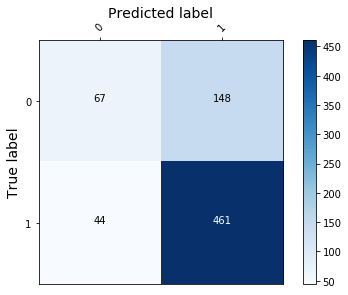

Accuracy =     0.733
Precision =     0.757
Recall (TPR) =  0.913
Fallout (FPR) = 0.688


In [14]:
lrn = LogisticRegression(penalty='l1')  #l1 penalty performs slightly better than l2 penalty

lrn.fit(X_train_scaled, y_train)
y_pred = lrn.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
acc, pr, tpr, fpr = show_data(cm, print_res = 1)

#### Accuracy is the percentage of correct predictions (classifications) made by the model.
#### Precision is the probability that a film that is classified as profitable actually made money.
#### Recall (True Positive Rate) is the probability that a profitable film is classified as such.
#### Fallout (False Positive Rate) is the probability that an unprofitable film is wrongly classified as profitable. **Really important to minimize fallout if we don't want to make unprofitable movies.**

In [15]:
np.mean(y_pred == y_test) #accuracy checks out

0.7333333333333333

### Parameter tuning - looking at ROC curves & confusion matrices

#### Functions to plot ROC. Source: https://www.kaggle.com/dstuerzer/optimized-logistic-regression

In [16]:
def ROC(X, y, c, r):
#makes cross_validation for given parameters c,r. Returns FPR, TPR (averaged)
    dic_weight = {1:len(y)/(r*np.sum(y)), 0:len(y)/(len(y)-r*np.sum(y))} 
    #unfortunately this takes too long to run with l1 penalty, so looking at l2
    lrn = LogisticRegression(penalty = 'l2', C = c, class_weight = dic_weight,
                             solver='liblinear') #specifying default solver to avoid a zillion warnings printing
    
    N = 5      #how much k-fold
    N_iter = 3    #repeat how often (taking the mean)
    mean_tpr = 0.0
    mean_thresh = 0.0
    mean_fpr = np.linspace(0, 1, 50000)
    

    for it in range(N_iter):
        skf = StratifiedKFold(n_splits = N, shuffle = True)
        for train_index, test_index in skf.split(X, y):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]
         
            lrn.fit(X_train, y_train)
            y_prob = lrn.predict_proba(X_test)[:,lrn.classes_[1]]
            
            fpr, tpr, thresholds = roc_curve(y_test, y_prob)
            mean_tpr += np.interp(mean_fpr, fpr, tpr)
            mean_thresh += np.interp(mean_fpr, fpr, thresholds)
            mean_tpr[0] = 0.0

    mean_tpr /= (N*N_iter)
    mean_thresh /= (N*N_iter)
    mean_tpr[-1] = 1.0
    return mean_fpr, mean_tpr, roc_auc_score(y_test, y_prob), mean_thresh

def plot_roc(X,y, list_par_1, par_1 = 'C', par_2 = 1):

    f = plt.figure(figsize = (9,6));
    for p in list_par_1:
        if par_1 == 'C':
            c = p
            r = par_2
        else:
            r = p
            c = par_2
        list_FP, list_TP, AUC, mean_thresh = ROC(X, y, c, r)      
        plt.plot(list_FP, list_TP, label = 'C = {}, r = {}, TPR(3e-4) = {:.4f}, AUC = {:.4f}'.format(c,r,list_TP[10],AUC));
    plt.legend(title = 'values', loc='lower right')
    plt.xlim(0, 1)   #we are only interested in small values of FPR
    plt.ylim(0, 1)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC detail')
    desired_fpr = 0.2
    plt.axvline(desired_fpr, color='b', linestyle='dashed', linewidth=2) #line to show where desired FPR occurs 
    plt.show()
    plt.close()

#### Casual/visual grid search 1: Look for optimal class_weight, 'r'

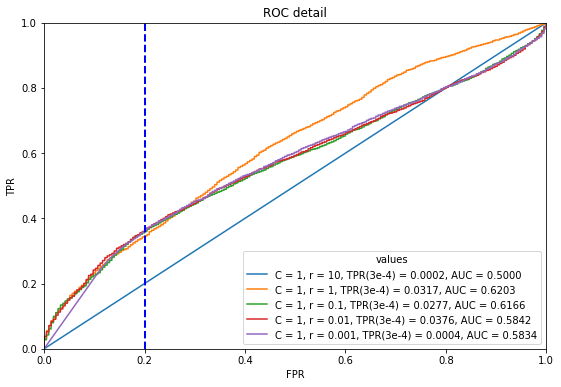

In [17]:
plot_roc(X,y, [10, 1,.1,.01,.001], 'r', 1)
# looks like r = 1 (default) is best overall
# I think this makes sense because we did stratified train-test split earlier

#### Casual/visual grid search 2: Look for optimal 'C' (inverse regularization strength)

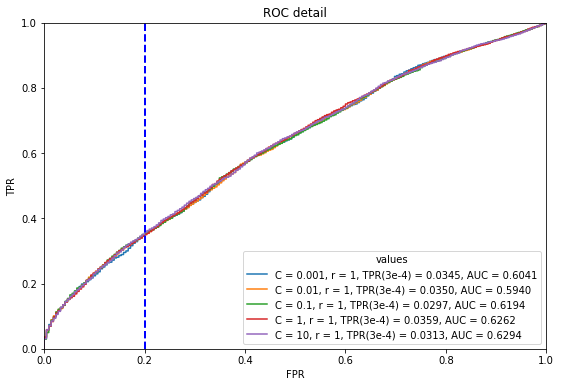

In [18]:
plot_roc(X,y, [0.001, 0.01, 0.1, 1, 10], 'C', 1)
# differences are so small it hardly matters
# running this repeatedly shows no pattern in terms of one C value standing out
# so we'll stick with the default C = 1.0

#### Casual/visual grid search 3: checking different decision boundaries - 60, 65, 70, 80%

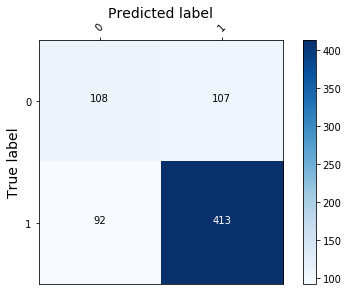

Accuracy =     0.724
Precision =     0.794
Recall (TPR) =  0.818
Fallout (FPR) = 0.498


In [19]:
y_pred = (lrn.predict_proba(X_test_scaled)[:,1] >= 0.6).astype(bool)

cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
acc, pr, tpr, fpr = show_data(cm, print_res = 1)

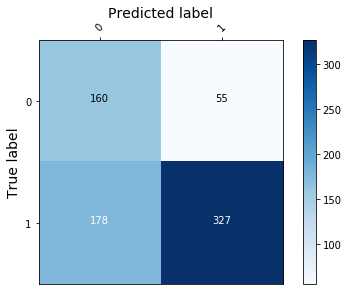

Accuracy =     0.676
Precision =     0.856
Recall (TPR) =  0.648
Fallout (FPR) = 0.256


In [20]:
y_pred = (lrn.predict_proba(X_test_scaled)[:,1] >= 0.7).astype(bool)

cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
acc, pr, tpr, fpr = show_data(cm, print_res = 1)

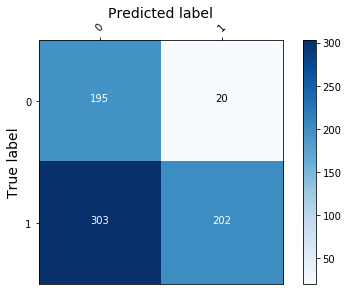

Accuracy =     0.551
Precision =     0.910
Recall (TPR) =  0.400
Fallout (FPR) = 0.093


In [21]:
y_pred = (lrn.predict_proba(X_test_scaled)[:,1] >= 0.8).astype(bool)

cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
acc, pr, tpr, fpr = show_data(cm, print_res = 1)

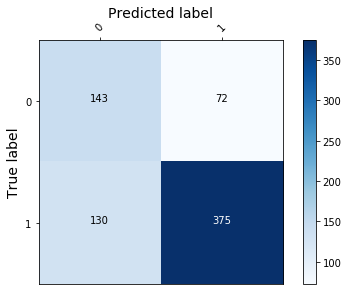

Accuracy =     0.719
Precision =     0.839
Recall (TPR) =  0.743
Fallout (FPR) = 0.335


In [22]:
y_pred = (lrn.predict_proba(X_test_scaled)[:,1] >= 0.65).astype(bool)

cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
acc, pr, tpr, fpr = show_data(cm, print_res = 1)

#### **Hard to say which decision boundary is optimal. We want to minimize FPR, but accuracy is getting trashed at higher thresholds. Time to try other models: SVM, RF, GB...**

## Support Vector Classification

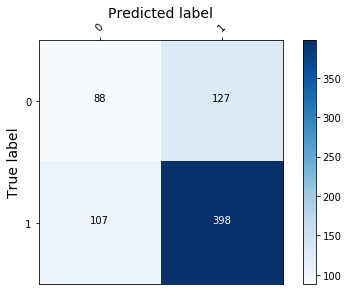

Accuracy =     0.675
Precision =     0.758
Recall (TPR) =  0.788
Fallout (FPR) = 0.591


In [23]:
svc = SVC(kernel='sigmoid')  #tried all kernels, SVC just doesn't do well for this

svc.fit(X_train_scaled, y_train)
y_pred = svc.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
acc, pr, tpr, fpr = show_data(cm, print_res = 1)

## Random Forest (RF)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


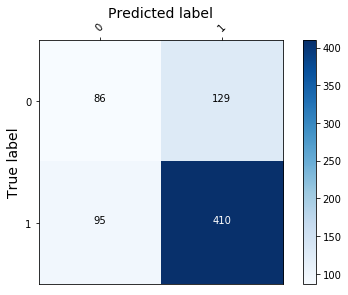

Accuracy =     0.689
Precision =     0.761
Recall (TPR) =  0.812
Fallout (FPR) = 0.600


In [24]:
# using scaled data (performs better):
rf = RandomForestClassifier()

rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
acc, pr, tpr, fpr = show_data(cm, print_res = 1)

## sklearn Gradient Boosting (GB)

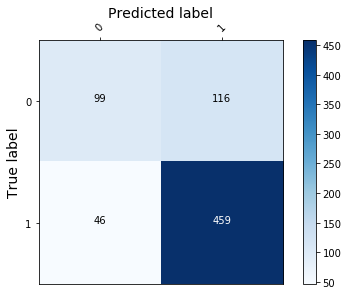

Accuracy =     0.775
Precision =     0.798
Recall (TPR) =  0.909
Fallout (FPR) = 0.540


In [25]:
# using scaled data (performs slightly better):

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=313)
for train_index, test_index in skf.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    break

gb = GradientBoostingClassifier() #

gb.fit(X_train_scaled, y_train)
y_pred = gb.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
acc, pr, tpr, fpr = show_data(cm, print_res = 1)

#### **GB does best. RF fallout only marginally lower.**
#### GB feature importances:

Feature ranking:
1 - releases
2 - budget
3 - fall
4 - adj_budget
5 - dir_prof
6 - compet_budget
7 - compet_cast_films
8 - compet_cast_dir_avg_rev
9 - compet_writ_prof
10 - compet_cast_rev
11 - compet_cast_prof_films
12 - Comedy
13 - cast_dir_avg_rev
14 - compet_dir_prof_films
15 - runtime
16 - writ_prof
17 - cast_films
18 - compet_adj_budget
19 - compet_dir_prof
20 - cast_prof_films
21 - cast_prof
22 - compet_cast_prof
23 - compet_dir_films
24 - cast_rev
25 - dir_rev
26 - compet_writ_prof_films


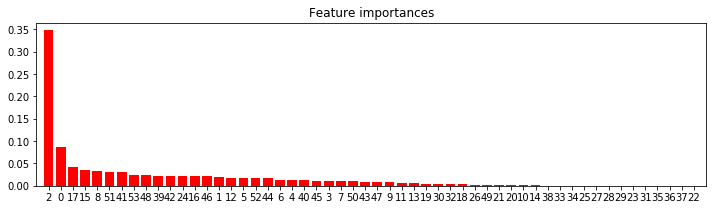

In [51]:
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

feat_imp_idxs = []
for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    feat_imp_idxs.append(indices[f])
    if importances[indices[f]] < 0.01:
        break
        
count = 0
for i in feat_imp_idxs:
    count += 1
    print(count, "-", list(df.loc[:, cols_X])[i])

# Plot the feature importances of the forest
plt.figure(figsize=(12,3))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## GB parameter tuning

In [56]:
parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10, 100]
    }

In [57]:
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

In [ ]:
clf.fit(X_train_scaled, y_train)

In [ ]:
## next step: pickle this model
## then: https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv

In [52]:
## final step: try different decision boundaries with tuned GB